# What is Tropical Cyclone Efficiency?

A key principle in treating a tropical cyclone as a thermal heat engine is the thermal maximum efficiency of the engine itself, $\eta$, which is given by

$\eta = \frac{T_s-T_0}{T_0}$

so that the ratio of the sea surface temperature ($T_s$) and outflow temperature ($T_0$) is critical important to how efficient the storm is at converting potential energy from the sea surface into kinetic energy in the form of wind speed.

In this notebook we explore the efficiency term by first calculating potential intensity and outflow temperature from ERA5 data, then analytically and empirically the climatological nature of the efficiency term.

### Setup

In [1]:
import sys
sys.path.append(sys.path[0]+'/..')
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
# load PI calculation module
from pyPI import *
# imports utility functions
from pyPI.utilities import *

### Load Data

In [2]:
# data location
data_loc='../data/sample_data.nc'
# load netcdf file
ds = xr.open_dataset(data_loc)

In [3]:
# create the function to output PI calculations
def run_sample_dataset(ds, pdim='p',CKCD=0.9,ascent_flag=0,diss_flag=1,V_reduc=0.8,ptop=50,miss_handle=1):
    """ This function calculates PI over an annual ERA5 dataset using xarray """
    
    # calculate PI over the whole data set using the xarray universal function
    result = xr.apply_ufunc(
        pi,
        ds['sst'], ds['msl'], ds[pdim], ds['t'], ds['q'],
        kwargs=dict(CKCD=CKCD, ascent_flag=ascent_flag, diss_flag=diss_flag, V_reduc=V_reduc, ptop=ptop, miss_handle=miss_handle),
        input_core_dims=[
            [], [], [pdim, ], [pdim, ], [pdim, ],
        ],
        output_core_dims=[
            [], [], [], [], []
        ],
        vectorize=True
    )

    # store the result in an xarray data structure
    vmax, pmin, ifl, t0, otl = result
    out_ds=xr.Dataset({
        'vmax': vmax, 
        'pmin': pmin,
        'ifl': ifl,
        't0': t0,
        'otl': otl,
        # merge the SST data into the same data structure, to aid efficiency calculations
        'sst': ds.sst+273.15,
        })
    
    # add names and units to the structure
    out_ds.vmax.attrs['standard_name'],out_ds.vmax.attrs['units']='Maximum Potential Intensity','m/s'
    out_ds.pmin.attrs['standard_name'],out_ds.pmin.attrs['units']='Minimum Central Pressure','hPa'
    out_ds.ifl.attrs['standard_name']='pyPI Flag'
    out_ds.t0.attrs['standard_name'],out_ds.t0.attrs['units']='Outflow Temperature','K'
    out_ds.otl.attrs['standard_name'],out_ds.otl.attrs['units']='Outflow Temperature Level','hPa'
    out_ds.sst.attrs['standard_name'],out_ds.otl.attrs['units']='Sea Surface Temperature','K'
    
    # save the pyPI calculation keywords
    out_ds.attrs['pyPI_parameter_CKCD']=CKCD
    out_ds.attrs['pyPI_parameter_ascent_flag']=ascent_flag
    out_ds.attrs['pyPI_parameter_diss_flag']=diss_flag
    out_ds.attrs['pyPI_parameter_V_reduc']=V_reduc
    out_ds.attrs['pyPI_parameter_ptop']=ptop
    out_ds.attrs['pyPI_parameter_miss_handle']=miss_handle

    # return the output from pi.py as an xarray data structure
    return out_ds

In [4]:
# calculate PI over the sample data
pi_ds=run_sample_dataset(ds)
pi_ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, month: 12)
Coordinates:
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * month    (month) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Data variables:
    vmax     (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    pmin     (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ifl      (month, lat, lon) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    t0       (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    otl      (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    sst      (month, lat, lon) float64 248.8 248.8 248.8 248.8 ... nan nan nan
Attributes:
    pyPI_parameter_CKCD:         0.9
    pyPI_parameter_ascent_flag:  0
    pyPI_parameter_diss_flag:    1
    pyPI_parameter_V_reduc:      0.8
    pyPI_parameter_ptop:         50
    pyPI_parameter_miss_handle:  1

### Efficiency function

In [5]:
Ts_range,T0_range=[297,303],[190,210]
Ts_grid,T0_grid=np.arange(Ts_range[0],Ts_range[-1]+1),np.arange(T0_range[0],T0_range[-1]+1)
Tsv, T0v = np.meshgrid(Ts_grid, T0_grid, sparse=False, indexing='ij')

In [7]:
eta=pi_efficiency(Tsv,T0v)

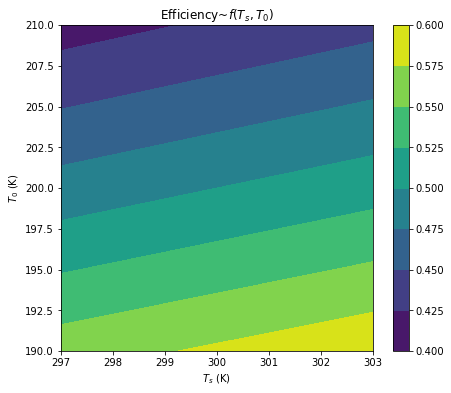

In [8]:
plt.figure(figsize=(7,6))
plt.contourf(Tsv,T0v,eta)
plt.xlabel('$T_s$ (K)')
plt.ylabel('$T_0$ (K)')
plt.colorbar()
plt.title('Efficiency~$f(T_s,T_0)$')
plt.show()

In [9]:
# calculate partial derivatives
depsdTs=(1/T0v)
depsdT0=-(Tsv/T0v**2)

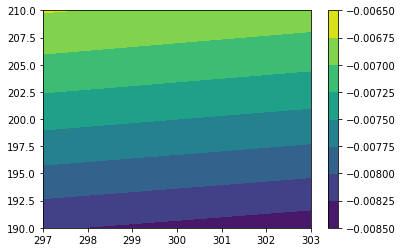

In [10]:
plt.contourf(Tsv,T0v,depsdT0)
plt.colorbar()

In [11]:
300/200-1

0.5

In [12]:
250/200-1

0.25

In [13]:
300/(200+10)-1

0.4285714285714286

In [14]:
250/(200+10)-1

0.19047619047619047

At higher SSTs, the loss of efficiency as outflow temperature increases is higher than at cooler SSTs.

### T_0 as a function of T_s

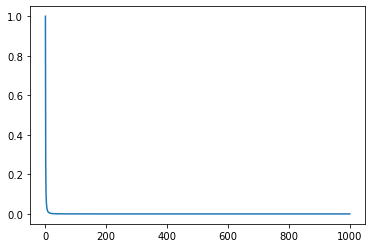

In [41]:
x=np.arange(1,1000)
fx=1/x**(2)
plt.plot(x,fx)

In [70]:
pi_ds.t0.max()

<xarray.DataArray 't0' ()>
array(298.00519414)

/Users/dgilford/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


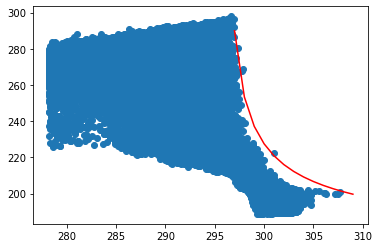

In [98]:
plt.scatter(pi_ds.sst,pi_ds.t0)
x=np.arange(296,310)
# good model form == fx = a/np.sqrt(x-b)+c
fx=125/np.sqrt(x-x.min())+165
plt.plot(x,fx,'r')
plt.show()

In [138]:
# remove outlier
geti=pi_ds.where(~np.logical_and(pi_ds.sst>300,pi_ds.t0>220))

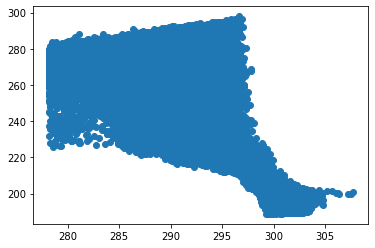

In [139]:
plt.scatter(geti.sst,geti.t0)

Efficiency calculation notebook

Explain efficiency/OTL… use skew-T/log-P

Load in ERA5 data

Calculate PI, get T0, calculate efficiency

Contour maps, function (DT0 vs. DSST), scatter plots

Questions/further to explore 
